# Import data

In [1]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<Axes: title={'center': 'a10 - Drug Sales Series'}, xlabel='date'>

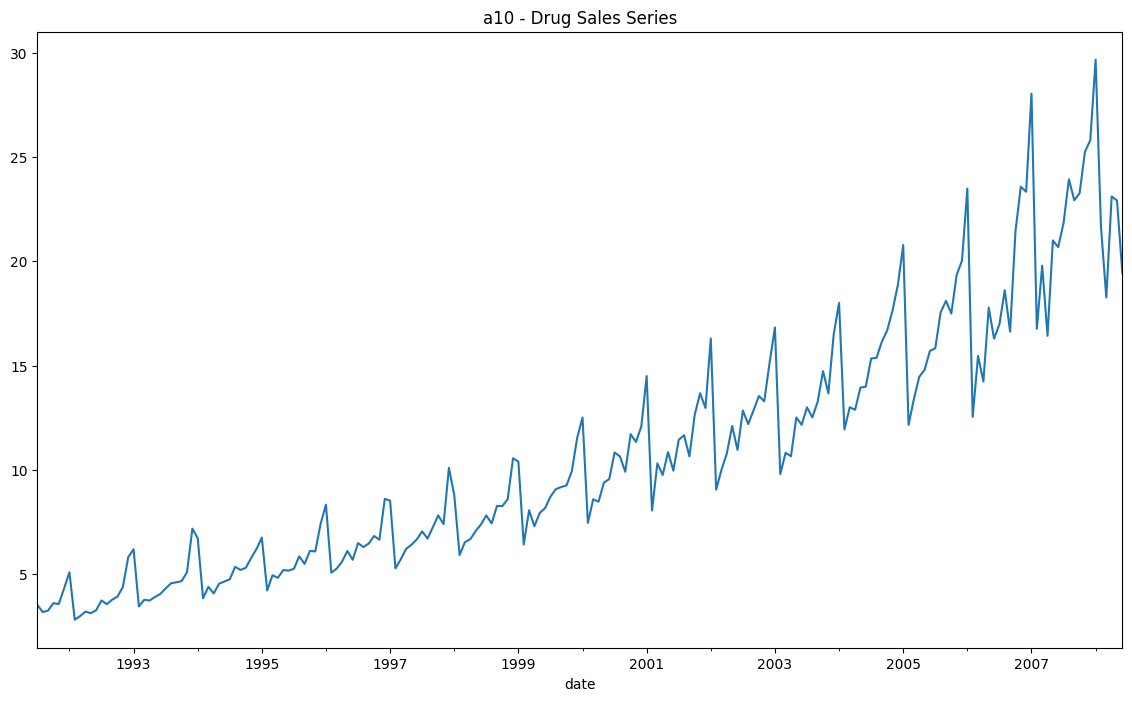

In [2]:
url = 'https://raw.githubusercontent.com/selva86/datasets/master/a10.csv'
df = pd.read_csv(url, parse_dates=['date'], index_col='date')
series = df.loc[:, 'value'].values
df.plot(figsize=(14,8), legend=None, title='a10 - Drug Sales Series')

# ADF test - check stationarity
We can use the augmented dickey-fuller (ADF) test for this

In [3]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

# autolag - let's the algorithm compute the optimal number of lags
result = adfuller(df.value.dropna(),autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('n lags: %f' % result[2])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: 3.145186
p-value: 1.000000
n lags: 15.000000
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476


## Interpretation
The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. There is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

# ARIMA Parameter Selection (Classical Method)
The Classial method is to use Box-Jenkins model identification ([wiki](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method))

## Differencing term (d)
From the wiki:
> non-stationarity is often indicated by an autocorrelation plot with very slow decay.

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

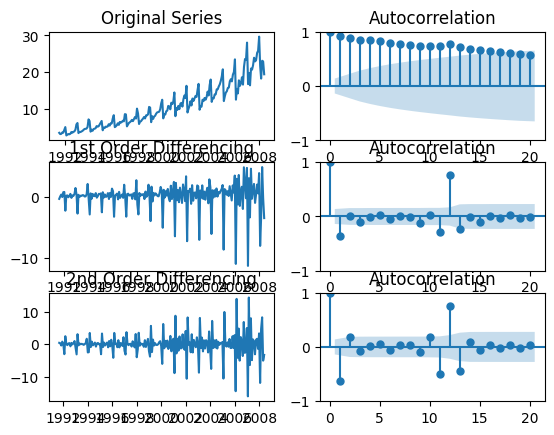

In [5]:
# ACF method

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, lags=20, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), lags=20, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), lags=20, ax=axes[2, 1])

plt.show()

this would appear that d = 1 would produce a function satisfying stationarity.

The spike at lag=12 indicates annual seasonality. We'll ignore this for now.

Let's double check with the ADF test

In [6]:
print('no differencing')
result = adfuller(df.value.dropna(),autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('n lags: %f' % result[2])

print('d1')
result = adfuller(df.value.diff().dropna(),autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('n lags: %f' % result[2])

print('d2')
result = adfuller(df.value.diff().diff().dropna(),autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('n lags: %f' % result[2])

no differencing
ADF Statistic: 3.145186
p-value: 1.000000
n lags: 15.000000
d1
ADF Statistic: -2.495172
p-value: 0.116653
n lags: 15.000000
d2
ADF Statistic: -10.292305
p-value: 0.000000
n lags: 14.000000


seems like we need d=2. But we can be conservative and use d=1, and be satisfied with "weak stationarity"

## Identify p and q
There are several methods to this. I'll skip this here; see [wiki](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method) for more info.

## We can use also use grid search to find the optimal parameters

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

In [8]:

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [9]:

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
            
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
                
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [10]:
# evaluate parameters
p_values = range(0, 3)
d_values = range(1)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=87.442
ARIMA(0, 0, 1) MSE=39.035
ARIMA(0, 0, 2) MSE=24.570
ARIMA(1, 0, 0) MSE=10.729
ARIMA(1, 0, 1) MSE=9.447
ARIMA(1, 0, 2) MSE=8.853
ARIMA(2, 0, 0) MSE=9.423
ARIMA(2, 0, 1) MSE=8.574
ARIMA(2, 0, 2) MSE=8.639
Best ARIMA(2, 0, 1) MSE=8.574


# Visualize the fit

In [11]:
X = df.value
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
# calculate out of sample error
error = mean_squared_error(test, predictions)

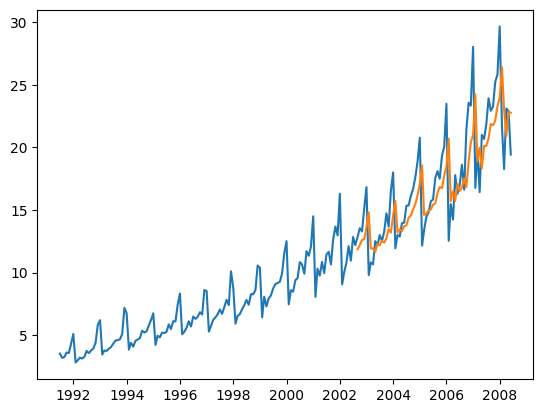

In [14]:
x_prediction = df.index[train_size:]
plt.plot(df)
plt.plot(x_prediction, predictions)
plt.show()

# SARIMA
Let's use a different package to make all this easier

In [15]:
import pmdarima as pm

In [16]:
model = pm.auto_arima(df.value, 
                      start_p=1, max_p=3,   # p search range
                      start_q=1, max_q=3,   # q search range
                      test='adf',           # use adftest to find optimal 'd'
                      m=12,                 # frequency of series
                      d=None,               # let model determine 'd'
                      seasonal=True,        # Include seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=732.050, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1310.028, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=687.892, Time=0.55 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1602.665, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=908.972, Time=0.08 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=684.282, Time=0.65 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=777.061, Time=0.47 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=684.499, Time=2.70 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=682.191, Time=1.72 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=741.656, Time=1.07 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=682.740, Time=3.59 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=802.567, Time=3.07 sec
 ARIMA(2,0,0)(1,0,2)[12] intercept   : 

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  204
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -286.073
Date:                              Thu, 16 Mar 2023   AIC                            590.147
Time:                                      19:27:15   BIC                            620.010
Sample:                                  07-01-1991   HQIC                           602.227
                                       - 06-01-2008                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3266      0.198     -1.653      0.098      -0.714       0.061
ar.L2          0.5459      0.131      4.177      0.000       0.290       0.802
ar.L3          0.7604      0.194      3.922      0.000       0.380       1.140
ma.L1          0.4273      0.218      1.964      0.049       0.001       0.854
ma.L2         -0.1531      0.137     -1.114      0.265      -0.422       0.116
ma.L3         -0.3655      0.181     -2.017      0.044      -0.721      -0.010
ar.S.L12       0.9771      0.017     57.779      0.000       0.944       1.010
ma.S.L12      -0.4435      0.081     -5.502      0.000      -0.602      -0.286
sigma2         0.8248      0.062     13.316      0.000       0.703       0.946
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               185.44
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              14.18   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

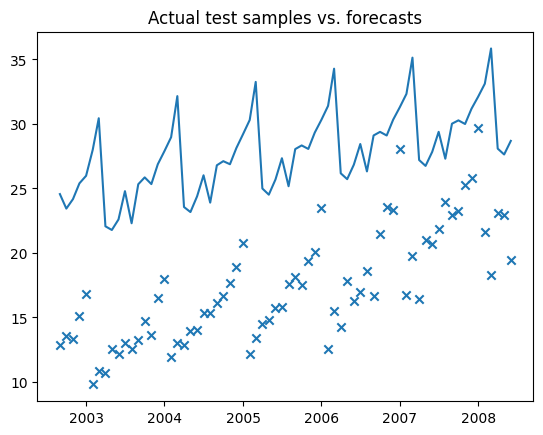

In [19]:
x_prediction = df.index[train_size:]

plt.scatter(x_prediction, test, marker='x')
plt.plot(x_prediction, model.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()